In [79]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
import genomeview
from pybedtools import BedTool
from plotting_utils import figure_path
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
pileup_cutoff = 3

preference_RNA = ['misc_RNA','srpRNA','SRP_RNA','vault_RNA','tRNA','snoRNA', 
                  'snRNA','scRNA','miRNA', 'rRNA','piRNA','RBP','SINE','SINE?',
                  'LINE','LINE?','Satellite','Simple_repeat',
                 'Low_complexity','LTR?','LTR', 'DNA','protein_coding']#,'RBP']
preference_rank = {rna:i for i, rna in zip(range(100), preference_RNA)}
max_rank = max(preference_rank.values()) + 1
def rank_type(rna):
    try:
        return preference_rank[rna]
    except KeyError:
        return max_rank + 1


def only_choice(row):
    # cases where only 1 potential RNA is found
    if row['gstrand'] == row['strand']:
        row['picked_RNA_sense'] = row['gname']
        row['picked_type_sense'] = row['gtype']
        row['picked_RNA_anti'] = '.'
        row['picked_type_anti'] = '.'
    else:
        row['picked_RNA_sense'] = '.'
        row['picked_type_sense'] = '.'
        row['picked_RNA_anti'] = row['gname']
        row['picked_type_anti'] = row['gtype']
    return row
    
def peak_info_table(row):
    peak_info = pd.DataFrame({'RNA': row['gname'].split(','),
                           'strand': row['gstrand'].split(','),
                           'peak_type': row['gtype'].split(',')}) \
        .assign(peak_rank = lambda d: d.peak_type.map(rank_type))\
        .assign(strand = lambda d: d.strand.astype(str))\
        .sort_values('peak_rank') \
        .reset_index()
    return peak_info
    
full_length_mRNA = '^HIST|^FT[LH]|^RP[LS]'
full_length_regex = re.compile(full_length_mRNA)
def rank_peaks(row):
    # multiple peak annotations
    peak_info = peak_info_table(row)
    
    for strand in ['-','+']:
        strand_peak_info = peak_info[(peak_info['strand'] == strand) | (peak_info['peak_type'].str.contains('Low|Simple|DNA'))]
        #print(strand, peak_info)
        stranding = '_sense' if row['strand'] == strand else '_anti'
        
        picked_RNA = 'picked_RNA' + stranding
        picked_type = 'picked_type' + stranding
        
        if strand_peak_info.shape[0] > 0:    
            row[picked_RNA] = strand_peak_info['RNA'].values[0]
            row[picked_type] = strand_peak_info['peak_type'].values[0]
        else:
            row[picked_RNA] = '.'
            row[picked_type] = '.'
            
            
        # correct for full length RNA
        full_mRNA_df = strand_peak_info[strand_peak_info.RNA.str.contains(full_length_mRNA)]
        if full_mRNA_df.shape[0] > 0 and row[picked_type] == "piRNA":
            row[picked_RNA] = full_mRNA_df.RNA.values[0]
            row[picked_type] = 'protein_coding'
    return row
            
        
def peak_assignment(args):
    # picked best represented peak type
    i, row = args
    
    RNA = ''
    peak_type = ''
    
    if ',' not in row['gstrand']:
        row = only_choice(row)
    else:
        # cases where several potential RNA
        row = rank_peaks(row)
    return row
    
lrna_regex = 'lincR|protein|pseudo|TR|proces|sense_intr'\
            'prime|IG|antisen|lncRNA|sense_ov|TEC'   
def merge_type(x):
    if re.search('LINE|Satellite|Simple_repeat|SINE|Unknown'
                 '|Low_complexity|LTR|^DNA$|^DNA\?$|RC|Other', x):
        return 'Repeats'

    elif x == ".":
        return 'Unannotated'
    
    elif re.search(lrna_regex, x):
        return 'Long RNA'
        
    elif re.search('rRNA|rDNA', x):
        return 'rRNA'
    elif re.search('misc|guid|scRN|srpRNA', x):
        return 'misc RNA'
    else:
        return x
    
def label_sense(picked_type_sense, picked_type_anti):
    label = '.'
    if picked_type_sense != ".":
        label = 'Sense'
    elif picked_type_anti != ".":
        label = "Antisense"
    else:
        label = 'Unannotated'
    return label

def load_peaks(filename):
    peak_df = pd.read_table(filename) 
    p = Pool(24)
    peaks = pd.DataFrame(p.map(peak_assignment, peak_df.iterrows()))
    p.close()
    p.join()
    peaks = peaks \
        .assign(pvalue = lambda d: np.power(10, -d.log10p))\
        .assign(picked_type_sense = lambda d: np.where((d.picked_RNA_sense.str.contains('HY')) & (d.picked_type_sense == 'scRNA'), 
                                             'misc RNA',
                                             d.picked_type_sense))\
        .assign(picked_type_sense = lambda d: np.where(d.picked_RNA_sense.str.contains('srpRNA'), 
                                             'misc RNA',
                                             d.picked_type_sense))\
        .assign(picked_type_sense = lambda d: np.where(d.picked_RNA_sense == "BC200", 'misc RNA', d.picked_type_sense))\
        .assign(merged_type = lambda d: d.picked_type_sense.map(merge_type)) \
        .assign(FDR = lambda d: p_adjust(d.pvalue) ) \
        .assign(is_sense = lambda d: list(map(label_sense, d.picked_RNA_sense, d.picked_RNA_anti))) \
        .fillna('.')
    return peaks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
project_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map'
peak_path = project_path + '/merged_bed/MACS2/annotated'
peak_tsv = peak_path + '/unfragmented.annotated_peaks.tsv'
hep_peak_tsv = peak_path + '/unfragmented.annotated_peaks_hepg2.tsv'
peak_df = load_peaks(peak_tsv)
peak_df.head()

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,gtype,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense
0,chr5,140090856,140091005,unfragmented.fwd_peak_2106,910140,+,16158.80566,91021.04688,91014.00000,25782.0,...,"misc_RNA,vault_RNA,RBP,RBP,RBP,RBP,RBP,RBP,RBP...","ENSG00000199990.1,NR_026703.1,XRCC6,XRCC6,XRCC...",.,.,VTRNA1-1,misc_RNA,0.0,misc RNA,0.0,Sense
1,chr14,50329264,50329578,unfragmented.rvs_peak_6033,869151,-,15071.40430,86922.44531,86915.16406,24211.0,...,"lincRNA,srpRNA,piRNA,piRNA,piRNA,piRNA,piRNA,p...","ENSG00000282885.1_1,srpRNA,piRNA,piRNA,piRNA,p...",.,.,RN7SL2,misc_RNA,0.0,misc RNA,0.0,Sense
2,chr14,50053028,50053621,unfragmented.fwd_peak_741,425348,+,7525.01074,42541.33984,42534.80859,14409.0,...,"RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RB...","DDX24,DROSHA,GEMIN5,IGF2BP2,PUM2,GEMIN5,DDX3X,...",SND1,RBP,7SLRNA,srpRNA,0.0,misc RNA,0.0,Sense
3,chr1,28975111,28975246,unfragmented.fwd_peak_53,112831,+,2275.88354,11289.51660,11283.18262,4467.0,...,"snRNA,lincRNA,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,...","NR_004407.1,ENSG00000270103.3_4,HNRNPM,HNRNPM,...",.,.,RNU11,snRNA,0.0,snRNA,0.0,Sense
4,chr5,140098506,140098621,unfragmented.fwd_peak_2107,59409,+,1229.19714,5947.22021,5940.94336,1744.0,...,"misc_RNA,vault_RNA,RBP,RBP,RBP,RBP,RBP,RBP,RBP...","ENSG00000202111.1,NR_026704.1,TROVE2,PUS1,PUS1...",.,.,VTRNA1-2,misc_RNA,0.0,misc RNA,0.0,Sense


In [81]:
hep_peak_df = load_peaks(hep_peak_tsv)

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,gtype,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense
0,chr5,140090856,140091005,unfragmented.fwd_peak_2106,910140,+,16158.80566,91021.04688,91014.00000,25782.0,...,"misc_RNA,vault_RNA,RBP,RBP,RBP,RBP,RBP,RBP,RBP...","ENSG00000199990.1,NR_026703.1,XRCC6,XRCC6,XRCC...",.,.,VTRNA1-1,misc_RNA,0.0,misc RNA,0.0,Sense
1,chr14,50329264,50329578,unfragmented.rvs_peak_6033,869151,-,15071.40430,86922.44531,86915.16406,24211.0,...,"lincRNA,srpRNA,piRNA,piRNA,piRNA,piRNA,piRNA,p...","ENSG00000282885.1_1,srpRNA,piRNA,piRNA,piRNA,p...",.,.,RN7SL2,misc_RNA,0.0,misc RNA,0.0,Sense
2,chr14,50053028,50053621,unfragmented.fwd_peak_741,425348,+,7525.01074,42541.33984,42534.80859,14409.0,...,"RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RB...","PRPF8,DDX24,DROSHA,SND1,DDX55,GEMIN5,IGF2BP2,P...",SF3B1,RBP,7SLRNA,srpRNA,0.0,misc RNA,0.0,Sense
3,chr1,28975111,28975246,unfragmented.fwd_peak_53,112831,+,2275.88354,11289.51660,11283.18262,4467.0,...,"snRNA,lincRNA,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,...","NR_004407.1,ENSG00000270103.3_4,HNRNPM,HNRNPM,...",.,.,RNU11,snRNA,0.0,snRNA,0.0,Sense
4,chr5,140098506,140098621,unfragmented.fwd_peak_2107,59409,+,1229.19714,5947.22021,5940.94336,1744.0,...,"misc_RNA,vault_RNA,RBP,RBP,RBP,RBP,RBP,RBP,RBP...","ENSG00000202111.1,NR_026704.1,CSTF2,TROVE2,PUS...",.,.,VTRNA1-2,misc_RNA,0.0,misc RNA,0.0,Sense


In [82]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
colors = np.random.RandomState(seed=1234).permutation(colors)
ce.fit(peak_df.merged_type, colors)

In [83]:
peak_df.query('pileup > 1').shape

(6169, 22)

In [84]:
peak_df\
        .assign(peak_count = 1)\
        .groupby(['merged_type', 'pileup'], as_index=False)\
        .agg({'peak_count':'sum'}) \
        .sort_values('pileup')\
        .reset_index() \
        .assign(cum_count = lambda d: d.groupby('merged_type').peak_count.cumsum())\
        .assign(log_pile = lambda d: d.pileup.transform(np.log10))\
        .query('merged_type == "Long RNA"')

,index,merged_type,pileup,peak_count,cum_count,log_pile
0,0,Long RNA,1.0,4119,4119,0.000000
16,1,Long RNA,2.0,964,5083,0.301030
26,2,Long RNA,3.0,158,5241,0.477121
36,3,Long RNA,4.0,43,5284,0.602060
42,4,Long RNA,5.0,26,5310,0.698970
47,5,Long RNA,6.0,8,5318,0.778151
56,6,Long RNA,7.0,16,5334,0.845098
65,7,Long RNA,8.0,7,5341,0.903090
77,8,Long RNA,9.0,5,5346,0.954243
85,9,Long RNA,10.0,4,5350,1.000000


In [85]:
def plot_peak_strand(peaks, ax):
    peaks\
        .query('pileup>=%i' %(pileup_cutoff))\
        .groupby('is_sense')\
        .agg({'picked_type_sense':'count'})\
        .reset_index() \
        .assign(index = lambda d: d['is_sense'] + '\n(' + d.picked_type_sense.astype(str)+')')\
        .set_index('index')\
        .plot.pie(y='picked_type_sense', explode = [0,0.05, 0.2], ax = ax)
    ax.set_ylabel('')
    ax.legend().set_visible(False)

In [86]:
    peak_pie= peaks\
        .query('is_sense == "Sense"')\
        .query('pileup>=%i' %(pileup_cutoff))\
        .groupby('merged_type', as_index=False)\
        .agg({'pvalue':'count'}) \
        .assign(fraction = lambda d: d.pvalue.transform(lambda x: 100*x/x.sum())) \
        .assign(merged_type = lambda d: d.merged_type + ' (' + d.pvalue.astype(str) + ')')\
        .set_index('merged_type')\
        .assign(explode = lambda d: (100-d.fraction)/100) \
        .assign(explode = lambda d: np.where(d.explode < 0.95,0, 
                                         np.where(d.explode < 0.99, 0.2,
                                                  np.where(d.explode < 0.994, 0.4, 0.8))))\
        .sort_values('pvalue', ascending=False)
    peak_pie

,pvalue,fraction,explode
merged_type,,,
RBP (588),588,35.766423,0.0
Repeats (336),336,20.437956,0.0
Long RNA (291),291,17.700730,0.0
snoRNA (168),168,10.218978,0.0
snRNA (104),104,6.326034,0.0
misc RNA (99),99,6.021898,0.0
miRNA (35),35,2.128954,0.2
piRNA (23),23,1.399027,0.2


In [87]:
peaks\
        .query('pileup>=%i' %(pileup_cutoff))\
        .groupby('merged_type', as_index=False)\
        .agg({'pvalue':'count'}) \
        .assign(fraction = lambda d: d.pvalue.transform(lambda x: 100*x/x.sum())) \
        .assign(merged_type = lambda d: d.merged_type + ' (' + d.pvalue.astype(str) + ')')\
        .set_index('merged_type')\
        .assign(explode = lambda d: (100-d.fraction)/100) \
        .assign(explode = lambda d: np.where(d.explode < 0.95,0, 
                                         np.where(d.explode < 0.99, 0.2,
                                                  np.where(d.explode < 0.994, 0.4, 0.8))))\
        .sort_values('pvalue', ascending=False)
        

list(map(lambda x: x.split('(')[0].strip(), peak_pie.index))

['RBP', 'Repeats', 'Long RNA', 'snoRNA', 'snRNA', 'misc RNA', 'miRNA', 'piRNA']

In [162]:
def plot_peak_pie(peaks, ax, ce):
    peak_pie= peaks\
        .query('pileup>=%i' %(pileup_cutoff))\
        .groupby('merged_type', as_index=False)\
        .agg({'pvalue':'count'}) \
        .assign(fraction = lambda d: d.pvalue.transform(lambda x: 100*x/x.sum())) \
        .assign(merged_type = lambda d: d.merged_type + ' (' + d.pvalue.astype(str) + ')')\
        .set_index('merged_type')\
        .assign(explode = lambda d: (100-d.fraction)/100) \
        .assign(explode = lambda d: np.where(d.explode < 0.95,0, 
                                         np.where(d.explode < 0.99, 0.2,
                                                  np.where(d.explode < 0.994, 0.4, 0.8))))\
        .sort_values('pvalue', ascending=False)
    
    rna_types = list(map(lambda x: x.split('(')[0].strip(), peak_pie.index))
    colors = ce.transform(rna_types)
    peak_pie.plot(kind = 'pie',
              y = 'fraction', 
              ax = ax,
              explode = peak_pie.explode,
              colors = colors)
    
    index = peak_pie.index
    ax.legend(bbox_to_anchor = (1.5,0.7), 
              labels = list(map(lambda x: x.split(' ')[0], index)), 
              ncol=2, 
              fontsize=12)
    
    ax.set_ylabel('')
    ax.legend().set_visible(False)


def plot_peak_bar(ax,peaks):
    for i, row in combined_peaks \
            .query('is_sense == "Sense" & pileup >= %i' %(pileup_cutoff)) \
            .groupby(['annotation','merged_type'],as_index=False) \
            .agg({'pvalue':'count'}) \
            .pipe(pd.pivot_table, index = 'merged_type', 
                    columns ='annotation', values = 'pvalue')\
            .iterrows():
                
        alpha = 1 if i in ['Long RNA','RBP'] else 0.5
        ax.plot([1,2], [row['K562'], row['K562 + HepG2']],
               color = ce.encoder[i], alpha=alpha)
        ax.scatter([1,2], [row['K562'], row['K562 + HepG2']],
               color = ce.encoder[i], alpha=alpha)
        x = 3 if i in ['misc RNA','miRNA'] else 2.1 
        ax.text(x, row['K562 + HepG2'], s = i, color = ce.encoder[i], fontsize=15)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['k562 only', 'K562 + HepG2'], 
                   rotation = 70, rotation_mode = 'anchor', ha = 'right')
    ax.set_xlim(0,3)
    ax.set_xlabel('ENCODE RNA binding-protein\nbinding site annotation')
    ax.set_ylabel('Number of peaks')
    sns.despine() 

In [89]:
def assign_rna_name(x):
    if re.search('RNY|Y_RNA|^HY', x):
        return 'Y-RNA'
    elif re.search('7SL|SRP', x):
        return '7SL RNA'
    elif re.search('7SK', x):
        return '7SK RNA'
    elif re.search('VTR', x):
        return 'Valut RNA'
    else:
        return x

def plot_misc(peaks, ax, ce):
    rnatype = 'Repeats'
    peaks\
        .query('merged_type == "%s"' %rnatype)\
        .query('pileup >= %i' %(pileup_cutoff)) \
        .assign(RNA_name = lambda d: d.picked_RNA_sense.map(assign_rna_name)) \
        .groupby('RNA_name', as_index=False)\
        .agg({'chrom':'count'}) \
        .nlargest(10, 'chrom')\
        .plot.bar('RNA_name','chrom', color = ce.encoder[rnatype], ax = ax)
    ax.set_xlabel('Repeat')
    ax.set_ylabel('Peak count')
    ax.legend().set_visible(False)

In [90]:
def plot_rbp(peaks, ax, ce):
    rbp_count = defaultdict(int)
    for i, row in peaks.query('pileup >= %i' %pileup_cutoff).iterrows():
        added = set()
        for btype, bp in zip(row['gtype'].split(','),
                        row['gname'].split(',')):
            if btype == "RBP":
                if bp not in added:
                    rbp_count[bp] += 1
                    added.add(bp)
    
    rbp_df = pd.DataFrame\
        .from_dict(rbp_count, orient='index')\
        .sort_values(0, ascending=False) 
    rbp_df.to_csv(figure_path + '/rbp_table.tsv', sep='\t')
    
    rbp_df.head(10).plot.bar(ax = ax, color = ce.encoder['RBP'])
    ax.legend().set_visible(False)
    ax.set_xlabel('RNA-binding protein')
    ax.set_ylabel('Number of protected\nRNA binding site')
    sns.despine()
    return rbp_df
    
def plot_long_RNA_peak(peaks, ax, ce):
    name_conversion = {'RP11-958N24.2': 'PKD1P4-NPIPA8',
                'RP11-163G10.3':'TMSB4X',
                'RP11-1212A22.4':'PKD1P5'}

    peaks[peaks.merged_type.str.contains('Long RNA')] \
        .nlargest(10, 'log10p')\
        .assign(picked_RNA_sense = lambda d: d.picked_RNA_sense\
                .map(lambda x: name_conversion[x] if x in name_conversion.keys() else x))\
        .plot.bar('picked_RNA_sense',
              'log10p',
              color = ce.encoder['Long RNA'],
             ax = ax)
    ax.legend().set_visible(False)
    ax.set_xlabel('Long RNA')
    ax.set_ylabel('-$log_{10}$ p-value')
    for i, xt in enumerate(ax.get_xticklabels()):
        if i in [0,1,3,4,6,7]:
            # intron
            xt.set_color('salmon')
        elif i in [2,8,9]:
            # full lengtj
            xt.set_color('skyblue')

In [91]:
ce.encoder

{'Long RNA': '#F05C3B',
 'RBP': '#8A9197',
 'RNA': '#1A9993',
 'Repeats': '#FED439',
 'Unannotated': '#91331F',
 'miRNA': '#C80813',
 'misc RNA': '#075149',
 'piRNA': '#709AE1',
 'snRNA': '#370335',
 'snoRNA': '#71D0F5'}

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Saved: /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_figure.pdf


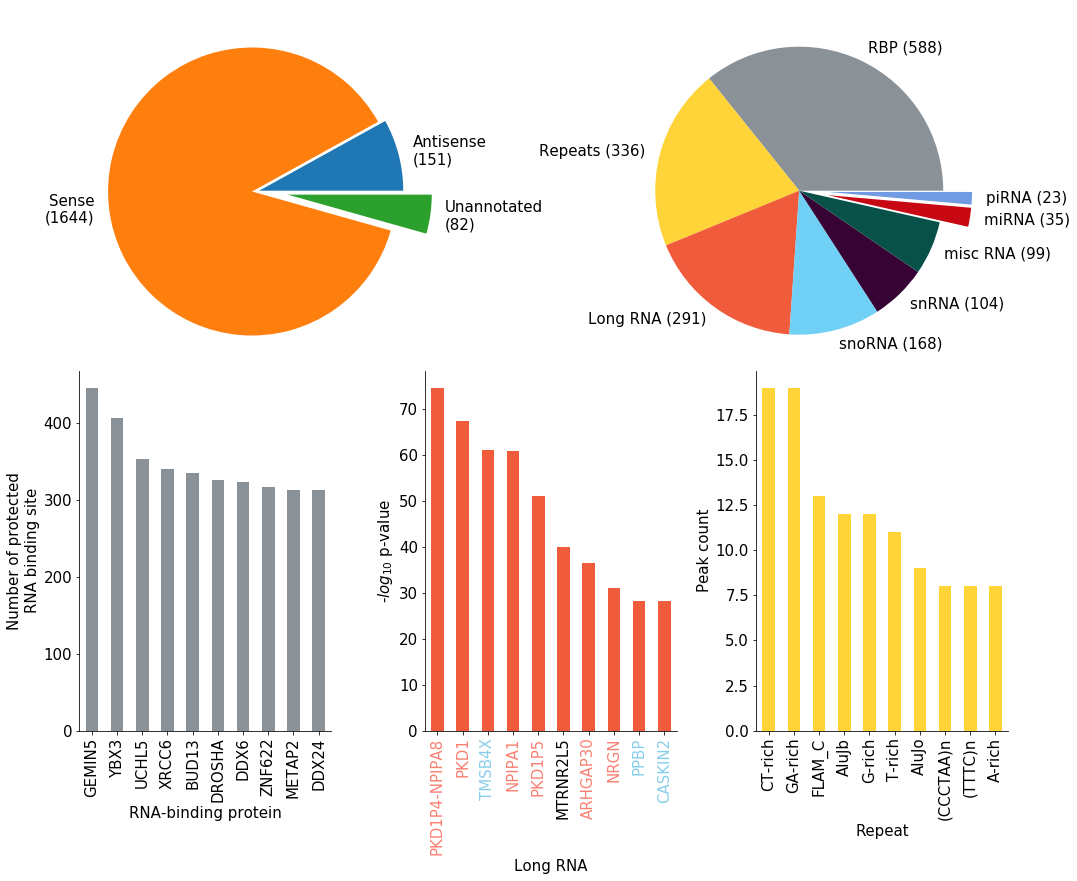

In [92]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.5, 0.5])
pie_ax = fig.add_axes([0.65, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_misc(sense_peaks, misc_ax, ce)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce)
plot_long_RNA_peak(peak_df, long_ax, ce)
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [139]:
peak_df.to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

In [140]:
def plot_peak_number(peaks,ax):
    for pt, pdf in peaks \
        .query('pileup >= %i' %pileup_cutoff)\
        .assign(peak_count = 1)\
        .groupby(['merged_type', 'pileup'], as_index=False)\
        .agg({'peak_count':'sum'}) \
        .sort_values('pileup')\
        .reset_index() \
        .assign(cum_count = lambda d: d.groupby('merged_type').peak_count.cumsum())\
        .assign(log_pile = lambda d: d.pileup.transform(np.log10))\
        .groupby('merged_type'):
        ax.plot(np.append(0, pdf['log_pile']),np.append(0,pdf['cum_count']), label = pt, color = ce.encoder[pt])
    ax.legend(bbox_to_anchor=(1,1))
    ax.vlines(ymin=0, ymax=  600, x = np.log10(pileup_cutoff), color = 'red')
    ax.set_ylabel('Cumulative number of peaks')
    ax.set_xlabel('Coverage (number of fragments)')
    xrange = np.arange(5) 
    ax.set_xticks(xrange)
    xt = ax.set_xticklabels(['$10^{%i}$' %i for i in xrange])
    sns.despine()
    
def plot_peak_coverage(peaks,ax):
    xrange = np.arange(5)
    sns.distplot(np.log10(peaks.query('pileup >= 0').pileup), hist=False, ax = ax)
    ax.vlines(ymin=0, ymax=  10, x = np.log10(pileup_cutoff-1), color = 'red')
    ax.set_ylabel('Peaks (%)')
    ax.set_xlabel('Coverage (number of fragments)')
    ax.set_xticks(xrange)
    xt = ax.set_xticklabels(['$10^%i$' %i for i in xrange])
    sns.despine()   
    
def plot_cov_density(peaks, ax):
    
    for strand, strand_df in peaks\
                .assign(log_pile = lambda d: np.log10(d.pileup))\
                .query('pileup >= %i' %(pileup_cutoff))\
                .groupby('is_sense'):
        sns.distplot(strand_df['log_pile'], 
                     hist=False, 
                     ax = ax,
                    label = strand)
    ax.legend(bbox_to_anchor = (0.6,0.6), title='',fontsize=15)
    
    ax.vlines(ymin = -10, 
              ymax = cum_peak.cum_count.max() + 100,
              x = np.log10(pileup_cutoff),
             color = 'red')



    xrange = np.arange(5) 
    ax.set_xticks(xrange)
    xt = ax.set_xticklabels(['$10^{%i}$' %i for i in xrange])
    ax.set_xlim(xrange.min(),xrange.max() + 1)
    ax.set_xlabel('Coverage (number of fragments)')
    ax.set_ylabel('% peaks')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/peak_qc.pdf


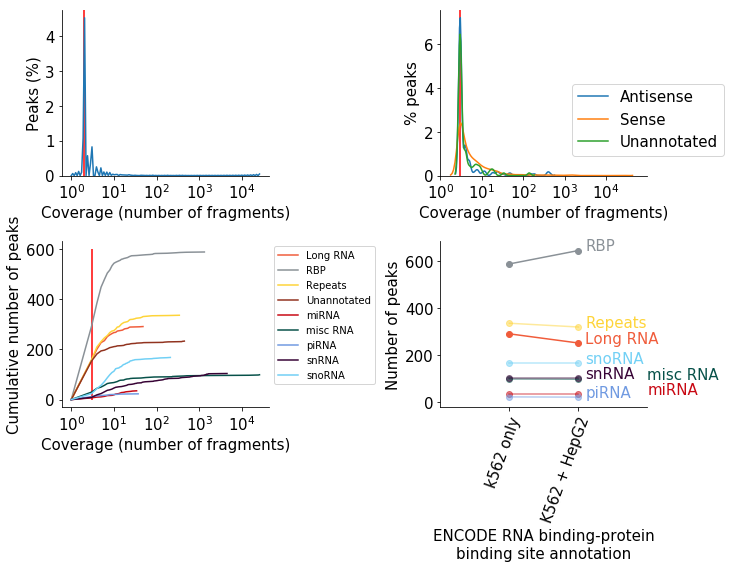

In [163]:
cum_peak = peaks.assign(peak_count = 1)\
    .groupby(['is_sense','pileup'], as_index=False)\
    .agg({'peak_count':'sum'}) \
    .assign(peak_count = lambda d: np.where(d.pileup <= pileup_cutoff,
                                 0,
                                 d.peak_count))\
    .sort_values('pileup') \
    .assign(cum_count = lambda d: d.groupby('is_sense')['peak_count'].cumsum())
    
    
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peaks, cov_ax)
plot_cov_density(peaks, dist_cov_ax)
plot_peak_number(peaks, number_ax)

#### add hepG2
combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)



Text(0,0.5,'Cumulative number of peaks')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


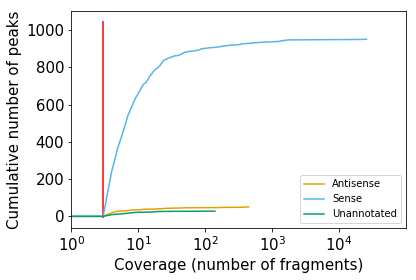

In [153]:

    
ax = plt.subplot(111)
color = okabeito_palette()
for col, (sense, sense_df) in zip(color, cum_peak.groupby('is_sense')):
    ax.plot(np.log10(sense_df['pileup']),sense_df['cum_count'], color = col, label = sense)
ax.legend()
ax.vlines(ymin = -10, 
          ymax = cum_peak.cum_count.max() + 100,
          x = np.log10(pileup_cutoff),
         color = 'red')

xrange = np.arange(5) 
ax.set_xticks(xrange)
xt = ax.set_xticklabels(['$10^{%i}$' %i for i in xrange])
ax.set_xlim(xrange.min(),xrange.max() + 1)
ax.set_xlabel('Coverage (number of fragments)')
ax.set_ylabel('Cumulative number of peaks')

In [154]:
peaks \
    .query('pileup >= 3 & is_sense == "Sense"') \
    .pipe(lambda d: d[d.gtype.str.contains(lrna_regex)]) \
    .groupby('merged_type')\
    .count()

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,gstrand,gtype,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,FDR,is_sense
merged_type,,,,,,,,,,,,,,,,,,,,,
Long RNA,259,259,259,259,259,259,259,259,259,259,...,259,259,259,259,259,259,259,259,259,259
RBP,587,587,587,587,587,587,587,587,587,587,...,587,587,587,587,587,587,587,587,587,587
Repeats,262,262,262,262,262,262,262,262,262,262,...,262,262,262,262,262,262,262,262,262,262
miRNA,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
misc RNA,69,69,69,69,69,69,69,69,69,69,...,69,69,69,69,69,69,69,69,69,69
piRNA,54,54,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
snRNA,53,53,53,53,53,53,53,53,53,53,...,53,53,53,53,53,53,53,53,53,53
snoRNA,163,163,163,163,163,163,163,163,163,163,...,163,163,163,163,163,163,163,163,163,163


In [148]:
peak_df\
    .query('pileup >= %s ' %(pileup_cutoff))\
    .pipe(lambda d: d[(d.merged_type.str.contains('RBP')) & (d.gtype.str.contains(lrna_regex))]).shape



(587, 22)

In [143]:
lR_peak = peaks[peaks.merged_type.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,gtype,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense
89,chr16,16468913,16469003,unfragmented.fwd_peak_914,689,+,23.68228,74.55307,68.97541,23.0,...,unprocessed_pseudogene,ENSG00000227827.3_4,.,.,RP11-958N24.2,unprocessed_pseudogene,2.798530e-75,Long RNA,7.920773e-73,Sense
98,chr16,2149771,2149861,unfragmented.rvs_peak_7257,619,-,22.24083,67.41602,61.98670,22.0,...,"protein_coding,protein_coding,protein_coding","NM_000296.3,NM_001009944.2,ENSG00000008710.19_3",.,.,PKD1,protein_coding,3.836896e-68,Long RNA,9.872449e-66,Sense
107,chr1,42965448,42965982,unfragmented.rvs_peak_415,563,-,19.26283,61.00228,56.30066,48.0,...,"processed_pseudogene,protein_coding","ENSG00000236876.3_3,ENSG00000186409.15_4",CCDC30,protein_coding,RP11-163G10.3,processed_pseudogene,9.947639e-62,Long RNA,2.303602e-59,Sense
111,chr16,15027133,15027223,unfragmented.fwd_peak_909,553,+,21.20949,60.79347,55.31452,21.0,...,"transcribed_unprocessed_pseudogene,protein_coding","ENSG00000183458.13_4,ENSG00000183426.16_3",.,.,NPIPA1,protein_coding,1.608904e-61,Long RNA,3.659250e-59,Sense
127,chr16,18470719,18470809,unfragmented.rvs_peak_7401,457,-,18.55546,51.06737,45.73625,18.0,...,"protein_coding,transcribed_unprocessed_pseudogene","ENSG00000233024.3,ENSG00000254681.6_2",.,.,RP11-1212A22.4,protein_coding,8.563080e-52,Long RNA,1.704120e-49,Sense
158,chr10,57359062,57359245,unfragmented.fwd_peak_289,346,+,13.75961,39.89572,34.60318,17.0,...,"protein_coding,protein_coding,protein_coding","ENSG00000249860.3_2,NM_001190478.1,ENSG0000015...",PCDH15,protein_coding,MTRNR2L5,protein_coding,1.271394e-40,Long RNA,2.049760e-38,Sense
167,chr1,161022152,161022229,unfragmented.rvs_peak_1265,313,-,12.66614,36.52526,31.33828,12.0,...,"protein_coding,protein_coding,protein_coding,p...","NM_001025598.1,NM_001287600.1,NM_001287602.1,N...",.,.,ARHGAP30,protein_coding,2.983596e-37,Long RNA,4.523877e-35,Sense
198,chr11,124609836,124609987,unfragmented.fwd_peak_494,259,+,11.04068,31.06145,25.93357,15.0,...,"protein_coding,protein_coding,protein_coding","ENSG00000154146.12_2,NM_001126181.1,NM_006176.2",.,.,NRGN,protein_coding,8.680605e-32,Long RNA,1.111161e-29,Sense
212,chr4,74851982,74853912,unfragmented.rvs_peak_14844,233,-,10.09181,28.22448,23.39759,39.0,...,"SINE,protein_coding,protein_coding,SINE","MIR,NM_002704.3,ENSG00000163736.3_2,MIR",MIRb,SINE,PPBP,protein_coding,5.963758e-29,Long RNA,7.098823e-27,Sense
214,chr17,73500561,73500652,unfragmented.rvs_peak_8618,230,-,10.66393,28.15385,23.06356,10.0,...,"protein_coding,protein_coding","NM_020753.4,ENSG00000177303.9_4",.,.,CASKIN2,protein_coding,7.016976e-29,Long RNA,8.313648e-27,Sense


In [157]:
def possible_peak(row):
    return ','.join(set(row['gtype'].split(',')))

peaks\
    .query('is_sense == "Antisense"')\
    .assign(possible = lambda d: [possible_peak(row) for i, row in d.iterrows()]) \
    .pipe(lambda d: d[d.possible.str.contains('protein_coding')]) \
    .pipe(lambda d: d[~d.gname.str.contains('^HB[A-Z]')])\
    .filter('chrom|start|end|picked_RNA_sense|merged_type|pileup|strand|log10p|is_sense'.split('|')) \
    .query('pileup >= %i' %(pileup_cutoff))\
    .sort_values('log10p', ascending=False)\
    .head(80)
#    .groupby('merged_type')\
#    .agg({'peak_strand':'count'})
#    .pipe(lambda d: d[d.merged_type.str.contains("RBP")]) \

,chrom,start,end,picked_RNA_sense,merged_type,pileup,strand,log10p,is_sense
66,chr11,5275567,5275958,.,Unannotated,186.0,+,146.66338,Antisense
159,chr17,33981897,33982065,.,Unannotated,24.0,-,39.26604,Antisense
177,chr6,118336959,118337060,.,Unannotated,32.0,-,34.18407,Antisense
263,chrX,12994372,12995344,.,Unannotated,19.0,-,23.74593,Antisense
558,chr11,14243028,14243120,.,Unannotated,4.0,-,12.35268,Antisense
647,chr7,120858558,120858674,.,Unannotated,4.0,-,11.26879,Antisense
702,chr15,45009835,45010318,.,Unannotated,7.0,-,10.26899,Antisense
750,chr14,33487816,33487901,.,Unannotated,3.0,-,10.20073,Antisense
759,chr15,73498625,73498778,.,Unannotated,3.0,-,10.15506,Antisense
806,chr2,72678650,72678723,.,Unannotated,3.0,+,10.07161,Antisense


In [158]:
peaks.pipe(lambda d: d[d.peakname.str.contains('all')])

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,gtype,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense


In [161]:
anti_peaks = peak_df \
    .assign(pvalue = lambda d: np.exp(-d['log10p'])) \
    .assign(picked_type_anti = lambda d: np.where((d.picked_RNA_anti.str.contains('HY')) & (d.picked_type_anti == 'scRNA'), 
                                             'misc_RNA',
                                             d.picked_type_anti))\
    .assign(picked_type_anti = lambda d: np.where(d.picked_RNA_anti.str.contains('srpRNA'), 
                                             'misc_RNA',
                                             d.picked_type_anti))\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .assign(FDR = lambda d: p_adjust(d.pvalue) ) \
    .assign(peak_strand = lambda d: np.where(d.peakname.str.contains('fwd'), '+','-')) \
    .query('pileup >= %i' %(pileup_cutoff))\
    .query('is_sense == "Antisense"') \
    .pipe(lambda d: d[~d.gname.str.contains('HB[A-Z]')])

anti_peaks\
    .sort_values('pileup', ascending=False)\
    .filter(regex = 'chrom|start|end|merged_type|fc|pileup|picked_RNA|peakname|strand|10p')\
    .pipe(lambda d: d[d.anti_merged_type.str.contains('misc|sn')])

,chrom,start,end,peakname,strand,fc,log10p,pileup,gstrand,picked_RNA_anti,picked_RNA_sense,merged_type,anti_merged_type,peak_strand
40,chr14,50329268,50329569,unfragmented.fwd_peak_743,+,121.43435,440.93707,152.0,"-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,...",RN7SL2,.,Unannotated,misc RNA,+
112,chr5,140090858,140090953,unfragmented.rvs_peak_16617,-,23.40749,60.67359,26.0,"+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,...",VTRNA1-1,.,Unannotated,misc RNA,-
244,chr6,52860415,52860742,unfragmented.rvs_peak_17448,-,9.03067,25.40399,12.0,"+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,...",RN7SK,.,Unannotated,misc RNA,-
302,chr14,50320392,50320633,unfragmented.fwd_peak_742,+,8.13808,21.16751,10.0,"-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-",RN7SL3,.,Unannotated,misc RNA,+
381,chr12,120729590,120729707,unfragmented.fwd_peak_628,+,6.52743,17.02042,8.0,"-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-",U4,.,Unannotated,snRNA,+
572,chr14,35015920,35016059,unfragmented.rvs_peak_5945,-,4.99572,12.05096,7.0,"+,+,+,+,+",U1,.,Unannotated,snRNA,-
934,chr1,149224054,149224220,unfragmented.fwd_peak_146,+,4.58686,9.54899,5.0,"-,-,-",RNVU1-18,.,Unannotated,snRNA,+
1131,chr1,147511065,147511161,unfragmented.fwd_peak_143,+,3.88818,8.65946,4.0,"-,-,-,-,-",RNVU1-7,.,Unannotated,snRNA,+
5496,chr9,135895715,135896505,unfragmented.rvs_peak_21612,-,2.36789,5.20143,3.0,"+,+,+,+,+,+,+,+,+,+,+",SNORD141A,.,Unannotated,snoRNA,-
1529,chr16,89627643,89628132,unfragmented.rvs_peak_7898,-,3.00521,7.32752,3.0,"+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,+,...",SNORD68,.,Unannotated,snoRNA,-


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


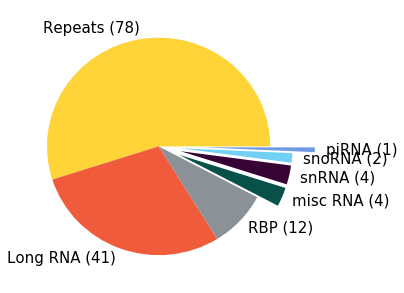

In [150]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plot_peak_pie(anti_peaks.assign(merged_type=lambda d: d["anti_merged_type"]), ax, ce)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0,0.5,'-$log_{10}$ p-value')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


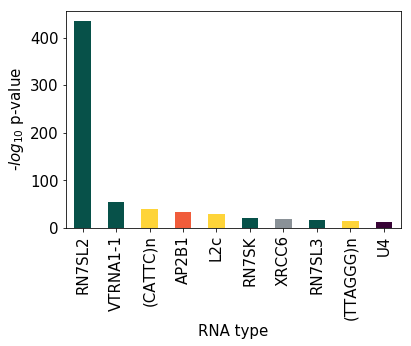

In [156]:
ax = plt.subplot(111)
anti_plot = anti_peaks.head(10)
anti_plot.plot\
    .bar('picked_RNA_anti', 'log10q', 
         colors = ce.transform(anti_plot\
                               .anti_merged_type),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')

In [96]:
bam_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam'
ref_path = '/stor/work/Lambowitz/ref/hg19'
tracks = {'DNase I': bam_path + '/unfragmented.bam',
         'NaOH': bam_path + '/alkaline_hydrolysis.bam',
         'sncRNA': ref_path + '/new_genes/sncRNA_viz.bed',
         'Protein': ref_path + '/new_genes/genes.bed12.bed'}
genome = ref_path + '/genome/hg19_genome.fa'

def color_func(interval):
    return 'salmon' if get_strand(interval.read) == '+' else 'steelblue'

regions = 'chr14:50329268-50329569'
matches = re.search('(chr[0-9XY]+):([0-9]+)-([0-9]+)', regions)
chrom, start, end = matches.groups()

viz = genomeview.visualize_data(tracks, chrom, int(start)-400, int(end)+400, genome)
for track in ['DNase I', 'NaOH']:
    tr = genomeview.get_one_track(viz, track)
    tr.color_fn = color_func
    if track == "DNase I":
        tr.row_height = 0.02

viz

In [115]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr10',57358980,57359246)

'CATTTATGTGGCAAAATAGTGAGAAGATTCATTAGTAGCAGTGACAAGCCTACGGAGGCTGGTGATAGCTGATTGTCCAAGGTAGAATTTTAGTTCAACTTTAAACTTAACCTACAGAATTACTTAATCCTCCTGTAAGTTTAACTGTTAAAGGGGGACGGATCTTCAGATACTAGAAAATAACCGTCCTATAGAGAGTAAAAGATTTTACCACCATAATTGGCCTAAAAGCAGCCACCAATTAAGAAAGCGTTTAAGCTCAACAT'

In [99]:
columns = peaks.columns
intron_df = BedTool()\
    .from_dataframe(peaks)\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8, s=True)\
    .to_dataframe(names = columns)
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-



(79, 22)

In [102]:
intron_df.query('pileup >=3')

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,gtype,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense
0,chr19,11333582,11333668,unfragmented.rvs_peak_9396,5761,-,156.11090,582.06433,576.11249,175.0,...,"RBP,RBP,protein_coding,protein_coding","METAP2,METAP2,NM_020812.3,ENSG00000130158.13_2",.,.,METAP2,RBP,0.000000e+00,RBP,0.000000e+00,Sense
1,chr16,2149772,2149861,unfragmented.rvs_peak_7257,619,-,22.24083,67.41602,61.98670,22.0,...,"protein_coding,protein_coding,protein_coding","NM_000296.3,NM_001009944.2,ENSG00000008710.19_3",.,.,PKD1,protein_coding,3.836896e-68,Long RNA,9.566536e-66,Sense
2,chr22,50356514,50356587,unfragmented.fwd_peak_1672,555,+,22.36177,60.99178,55.53426,25.0,...,"protein_coding,protein_coding,miRNA,RBP,RBP,RB...","NM_001001852.3,ENSG00000198355.4_2,NR_106879.1...",.,.,MIR6821,miRNA,1.019108e-61,miRNA,2.275800e-59,Sense
3,chr16,15027134,15027223,unfragmented.fwd_peak_909,553,+,21.20949,60.79347,55.31452,21.0,...,"transcribed_unprocessed_pseudogene,protein_coding","ENSG00000183458.13_4,ENSG00000183426.16_3",.,.,NPIPA1,protein_coding,1.608904e-61,Long RNA,3.561918e-59,Sense
4,chr16,16425621,16425710,unfragmented.fwd_peak_913,474,+,18.62362,52.83084,47.41426,18.0,...,"unprocessed_pseudogene,protein_coding,misc_RNA","ENSG00000244257.5_2,ENSG00000183889.12_5,NR_03...",.,.,PKD1P1,misc_RNA,1.476250e-53,misc RNA,2.961843e-51,Sense
5,chr16,18470720,18470809,unfragmented.rvs_peak_7401,457,-,18.55546,51.06737,45.73625,18.0,...,"protein_coding,transcribed_unprocessed_pseudogene","ENSG00000233024.3,ENSG00000254681.6_2",.,.,RP11-1212A22.4,protein_coding,8.563080e-52,Long RNA,1.641108e-49,Sense
6,chr15,91423005,91423096,unfragmented.fwd_peak_878,453,+,18.01665,50.72411,45.32993,18.0,...,"RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RB...","HNRNPM,HNRNPM,HNRNPM,HNRNPM,XRCC6,XRCC6,EFTUD2...",.,.,HNRNPM,RBP,1.887513e-51,RBP,3.564208e-49,Sense
7,chr17,39913789,39913885,unfragmented.rvs_peak_8287,432,-,16.63231,48.53362,43.24180,17.0,...,"RBP,RBP,protein_coding,protein_coding,protein_...","DHX30,XRCC6,ENSG00000173801.16_3,NM_002230.2,N...",.,.,DHX30,RBP,2.926712e-49,RBP,5.446442e-47,Sense
8,chr17,73500562,73500652,unfragmented.rvs_peak_8618,230,-,10.66393,28.15385,23.06356,10.0,...,"protein_coding,protein_coding","NM_020753.4,ENSG00000177303.9_4",.,.,CASKIN2,protein_coding,7.016976e-29,Long RNA,8.009021e-27,Sense
9,chr6,31323001,31323093,unfragmented.rvs_peak_17246,212,-,9.14821,26.33225,21.28976,9.0,...,"protein_coding,miRNA,protein_coding","NM_005514.7,NR_106951.1,ENSG00000234745.10_2",.,.,MIR6891,miRNA,4.653182e-27,miRNA,4.917628e-25,Sense


In [111]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

,start,end,score,fc,log10p,log10q,pileup,pvalue,FDR,length
count,3.000000e+01,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,3.000000e+01,30.000000
mean,5.288270e+07,5.288280e+07,390.833333,14.326341,44.022753,39.118338,14.533333,9.390590e-10,1.856872e-08,97.166667
std,3.764793e+07,3.764793e+07,1030.536622,27.493260,103.308579,103.049562,31.024721,2.422037e-09,4.597509e-08,19.093388
min,2.149772e+06,2.149861e+06,37.000000,3.473550,7.973160,3.733770,3.000000,0.000000e+00,0.000000e+00,73.000000
25%,2.168379e+07,2.168388e+07,58.250000,4.184283,10.507725,5.870862,4.000000,1.754244e-29,2.002255e-27,86.250000
50%,5.005730e+07,5.005741e+07,155.000000,7.739050,20.445675,15.515200,7.000000,5.380082e-21,4.184903e-19,89.000000
75%,6.511963e+07,6.511974e+07,381.500000,15.140215,43.438678,38.197240,15.250000,6.302543e-11,2.016974e-09,107.250000
max,1.456217e+08,1.456218e+08,5761.000000,156.110900,582.064330,576.112490,175.000000,1.063751e-08,1.976714e-07,141.000000


In [103]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
querying 1-30...done.


In [ ]:
anti_peaks\
    .sort_values('log10p', ascending=False) \
    .query('merged_type=="Repeats"')

In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [83]:
import gseapy as gsp

In [84]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [51]:
peaks.query('merged_type	=="piRNA"')

,chrom,start,end,peakname,score,strand,fc,log10p,log10q,pileup,...,gtype,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense
153,chr9,5093671,5093964,unfragmented.fwd_peak_2599,362,+,13.95867,41.27092,36.20305,37.0,...,"piRNA,protein_coding,protein_coding,protein_co...","piRNA,ENSG00000096968.13_3,NM_001322194.1,NM_0...",.,.,piR-hsa-1847,piRNA,5.358954e-42,piRNA,8.864196e-40,Sense
282,chr7,141504962,141505178,unfragmented.rvs_peak_19376,173,-,8.25417,22.25786,17.30792,12.0,...,piRNA,piRNA,.,.,piR-hsa-1847,piRNA,5.522554e-23,piRNA,4.953381e-21,Sense
433,chr19,1272776,1273020,unfragmented.fwd_peak_1140,105,+,5.99779,15.30490,10.53325,8.0,...,"protein_coding,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP...","NM_001300815.1,FAM120A,UPF1,GPKOW,TROVE2,GPKOW...",piR-hsa-7551,piRNA,piR-hsa-11559,piRNA,4.955643e-16,piRNA,2.963265e-14,Sense
546,chr7,137198563,137198850,unfragmented.fwd_peak_2460,79,+,5.19158,12.49231,7.93546,7.0,...,"piRNA,processed_pseudogene,piRNA,protein_codin...","piRNA,ENSG00000279483.2_3,piRNA,ENSG0000015768...",piR-hsa-27278,piRNA,piR-hsa-15610,piRNA,3.218770e-13,piRNA,1.493474e-11,Sense
650,chr1,96912715,96913488,unfragmented.fwd_peak_112,65,+,4.46836,10.90544,6.59085,8.0,...,"processed_pseudogene,piRNA,RBP,RBP,RBP,piRNA,RBP","ENSG00000228502.1_3,piRNA,YBX3,YBX3,YBX3,piRNA...",.,.,piR-hsa-16348,piRNA,1.243254e-11,piRNA,4.769491e-10,Sense
677,chr7,22549930,22551681,unfragmented.rvs_peak_18487,62,-,4.05684,10.54202,6.28936,14.0,...,"LINE,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,RBP,proce...","L1,LARP4,RBM22,PPIL4,YBX3,YBX3,YBX3,YBX3,YBX3,...",.,.,piR-hsa-20701,piRNA,2.870648e-11,piRNA,1.055181e-09,Sense
731,chr6,153603463,153603891,unfragmented.rvs_peak_18136,56,-,3.89618,10.06609,5.64859,7.0,...,"processed_pseudogene,RBP,RBP,RBP,RBP,RBP,RBP,R...","ENSG00000218426.5_4,IGF2BP2,UCHL5,SND1,DDX6,YB...",RP11-306O13.1,lincRNA,piR-hsa-30977,piRNA,8.588355e-11,piRNA,2.779812e-09,Sense
859,chr2,32468725,32469154,unfragmented.fwd_peak_1298,52,+,3.96930,9.87859,5.28030,3.0,...,"SINE,piRNA,LINE,SINE,protein_coding,protein_co...","Alu,piRNA,L1,Alu,NM_001302504.1,NM_021209.4,EN...",NLRC4,protein_coding,piR-hsa-30937,piRNA,1.322544e-10,piRNA,4.024988e-09,Sense
938,chr17,71291834,71291927,unfragmented.fwd_peak_1071,50,+,3.95329,9.51956,5.00704,3.0,...,"SINE,piRNA,protein_coding,protein_coding","Alu,piRNA,NM_012121.4,ENSG00000179604.9_2",CDC42EP4,protein_coding,piR-hsa-27032,piRNA,3.023013e-10,piRNA,8.361043e-09,Sense
997,chr1,145438514,145438801,unfragmented.fwd_peak_137,48,+,3.76846,9.29814,4.83329,4.0,...,"RBP,RBP,RBP,RBP,RBP,piRNA,piRNA,RBP,RBP,RBP,RB...","QKI,DDX3X,NCBP2,DDX3X,FXR1,piRNA,piRNA,DDX6,FT...",.,.,piR-hsa-4275,piRNA,5.033383e-10,piRNA,1.292494e-08,Sense


In [64]:
import mappy as mp

mt = 0
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
mts = []
piRNA = peaks.query('merged_type == "piRNA"').reset_index()
for i, row in piRNA.iterrows():
    seq = fa.fetch(row['chrom'], row['start'], row['end'])
    seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
    alns = aligner.map(seq)
    try:
        aln = next(alns)
        mt += 1
        mts.append('MT')
        #print(aln.cigar_str)
    except StopIteration:
        #print(row)
        mts.append('no')
        pass


print(mt, i)

2 327


In [65]:
piRNA['is_mt'] = mts
piRNA

,index,chrom,start,end,peakname,score,strand,fc,log10p,log10q,...,gid,picked_RNA_anti,picked_type_anti,picked_RNA_sense,picked_type_sense,pvalue,merged_type,FDR,is_sense,is_mt
0,153,chr9,5093671,5093964,unfragmented.fwd_peak_2599,362,+,13.95867,41.27092,36.20305,...,"piRNA,ENSG00000096968.13_3,NM_001322194.1,NM_0...",.,.,piR-hsa-1847,piRNA,5.358954e-42,piRNA,8.864196e-40,Sense,MT
1,282,chr7,141504962,141505178,unfragmented.rvs_peak_19376,173,-,8.25417,22.25786,17.30792,...,piRNA,.,.,piR-hsa-1847,piRNA,5.522554e-23,piRNA,4.953381e-21,Sense,MT
2,433,chr19,1272776,1273020,unfragmented.fwd_peak_1140,105,+,5.99779,15.30490,10.53325,...,"NM_001300815.1,FAM120A,UPF1,GPKOW,TROVE2,GPKOW...",piR-hsa-7551,piRNA,piR-hsa-11559,piRNA,4.955643e-16,piRNA,2.963265e-14,Sense,no
3,546,chr7,137198563,137198850,unfragmented.fwd_peak_2460,79,+,5.19158,12.49231,7.93546,...,"piRNA,ENSG00000279483.2_3,piRNA,ENSG0000015768...",piR-hsa-27278,piRNA,piR-hsa-15610,piRNA,3.218770e-13,piRNA,1.493474e-11,Sense,no
4,650,chr1,96912715,96913488,unfragmented.fwd_peak_112,65,+,4.46836,10.90544,6.59085,...,"ENSG00000228502.1_3,piRNA,YBX3,YBX3,YBX3,piRNA...",.,.,piR-hsa-16348,piRNA,1.243254e-11,piRNA,4.769491e-10,Sense,no
5,677,chr7,22549930,22551681,unfragmented.rvs_peak_18487,62,-,4.05684,10.54202,6.28936,...,"L1,LARP4,RBM22,PPIL4,YBX3,YBX3,YBX3,YBX3,YBX3,...",.,.,piR-hsa-20701,piRNA,2.870648e-11,piRNA,1.055181e-09,Sense,no
6,731,chr6,153603463,153603891,unfragmented.rvs_peak_18136,56,-,3.89618,10.06609,5.64859,...,"ENSG00000218426.5_4,IGF2BP2,UCHL5,SND1,DDX6,YB...",RP11-306O13.1,lincRNA,piR-hsa-30977,piRNA,8.588355e-11,piRNA,2.779812e-09,Sense,no
7,859,chr2,32468725,32469154,unfragmented.fwd_peak_1298,52,+,3.96930,9.87859,5.28030,...,"Alu,piRNA,L1,Alu,NM_001302504.1,NM_021209.4,EN...",NLRC4,protein_coding,piR-hsa-30937,piRNA,1.322544e-10,piRNA,4.024988e-09,Sense,no
8,938,chr17,71291834,71291927,unfragmented.fwd_peak_1071,50,+,3.95329,9.51956,5.00704,...,"Alu,piRNA,NM_012121.4,ENSG00000179604.9_2",CDC42EP4,protein_coding,piR-hsa-27032,piRNA,3.023013e-10,piRNA,8.361043e-09,Sense,no
9,997,chr1,145438514,145438801,unfragmented.fwd_peak_137,48,+,3.76846,9.29814,4.83329,...,"QKI,DDX3X,NCBP2,DDX3X,FXR1,piRNA,piRNA,DDX6,FT...",.,.,piR-hsa-4275,piRNA,5.033383e-10,piRNA,1.292494e-08,Sense,no
